# Seasonality

### What is Seasonality?

Dizemos que uma série temporal exibe sazonalidade sempre que há uma mudança regular e periódica na média da série. As mudanças sazonais geralmente seguem o relógio e o calendário - repetições ao longo de um dia, uma semana ou um ano são comuns. A sazonalidade é muitas vezes impulsionada pelos ciclos do mundo natural ao longo de dias e anos ou por convenções de comportamento social em torno de datas e horas.

Aprenderemos dois tipos de recursos que modelam a sazonalidade. O primeiro tipo, indicadores, é melhor para uma estação com poucas observações, como uma estação semanal de observações diárias. O segundo tipo, características de Fourier, é melhor para uma estação com muitas observações, como uma estação anual de observações diárias.

Assim como usamos um gráfico de média móvel para descobrir a tendência em uma série, podemos usar um gráfico sazonal para descobrir padrões sazonais. Um gráfico sazonal mostra segmentos da série temporal plotados em relação a algum período comum, sendo o período a "estação" que você deseja observar.

### Seasonal indicators

#### Indicadores sazonais
Indicadores sazonais são recursos binários que representam diferenças sazonais no nível de uma série temporal. Os indicadores sazonais são o que você obtém se tratar um período sazonal como um recurso categórico e aplicar a codificação one-hot.

Por dias de codificação únicos da semana, obtemos indicadores sazonais semanais. A criação de indicadores semanais para a série Trigonometria nos fornecerá seis novos recursos "dummy". (A regressão linear funciona melhor se você descartar um dos indicadores; escolhemos segunda-feira no quadro abaixo.)

<img src="img/c.png">

Adicionar indicadores sazonais aos dados de treinamento ajuda os modelos a distinguir as médias dentro de um período sazonal:

<img src="img/d.png">

Os indicadores funcionam como interruptores de ligar/desligar. A qualquer momento, no máximo um desses indicadores pode ter o valor 1 (On). A regressão linear aprende um valor de linha de base 2379 para Mon e, em seguida, ajusta pelo valor de qualquer indicador que esteja Ligado para aquele dia; o resto é 0 e desaparece.

### Características de Fourier e o Periodograma
O tipo de recurso que discutimos agora é mais adequado para longas temporadas em muitas observações onde os indicadores seriam impraticáveis. Em vez de criar um recurso para cada data, os recursos de Fourier tentam capturar a forma geral da curva sazonal com apenas alguns recursos.

Vamos dar uma olhada em um gráfico para a temporada anual em Trigonometria. Observe as repetições de várias frequências: um movimento longo para cima e para baixo três vezes por ano, movimentos semanais curtos 52 vezes por ano e talvez outros.

<img src="img/e.png">

São essas frequências dentro de uma estação que tentamos capturar com características de Fourier. A ideia é incluir em nossos dados de treinamento curvas periódicas com as mesmas frequências da temporada que estamos tentando modelar. As curvas que usamos são as das funções trigonométricas seno e cosseno.

As características de Fourier são pares de curvas seno e cosseno, um par para cada frequência potencial na estação começando pela mais longa. Os pares de Fourier que modelam a sazonalidade anual teriam frequências: uma vez por ano, duas vezes por ano, três vezes por ano e assim por diante.

<img src="img/f.png">

Se adicionarmos um conjunto dessas curvas seno/cosseno aos nossos dados de treinamento, o algoritmo de regressão linear descobrirá os pesos que se ajustarão ao componente sazonal na série de destino. A figura ilustra como a regressão linear usou pares de Fourier para modelar a sazonalidade anual na série Wiki Trigonometria.

<img src="img/g.png">

Observe que precisamos apenas de oito feições (quatro pares seno/cosseno) para obter uma boa estimativa da sazonalidade anual. Compare isso com o método do indicador sazonal que exigiria centenas de recursos (um para cada dia do ano). Ao modelar apenas o "efeito principal" da sazonalidade com recursos de Fourier, você geralmente precisará adicionar muito menos recursos aos seus dados de treinamento, o que significa tempo de computação reduzido e menos risco de overfitting.

### Escolhendo características de Fourier com o Periodograma
Quantos pares de Fourier devemos incluir em nosso conjunto de recursos? Podemos responder a esta pergunta com o periodograma. O periodograma informa a força das frequências em uma série temporal. Especificamente, o valor no eixo y do gráfico é (a ** 2 + b ** 2) / 2, onde a e b são os coeficientes do seno e cosseno nessa frequência (como no gráfico de componentes de Fourier acima ).

<img src="img/h.png">

Da esquerda para a direita, o periodograma cai após Trimestral, quatro vezes por ano. Foi por isso que escolhemos quatro pares de Fourier para modelar a temporada anual. A frequência semanal ignoramos, pois é melhor modelada com indicadores.

### Recursos de computação de Fourier (opcional)
Saber como os recursos de Fourier são calculados não é essencial para usá-los, mas se ver os detalhes esclarecer as coisas, a célula oculta da célula abaixo ilustra como um conjunto de recursos de Fourier pode ser derivado do índice de uma série temporal. (No entanto, usaremos uma função de biblioteca de statsmodels para nossos aplicativos.)

In [1]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

### Exemplo - Tráfego de Túnel
Continuaremos mais uma vez com o conjunto de dados de Tráfego de Túnel. Essa célula oculta carrega os dados e define duas funções: sazonal_plot e plot_periodogram.

In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


tunnel = pd.read_csv("pasta/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

Vamos dar uma olhada nas parcelas sazonais ao longo de uma semana e mais de um ano.

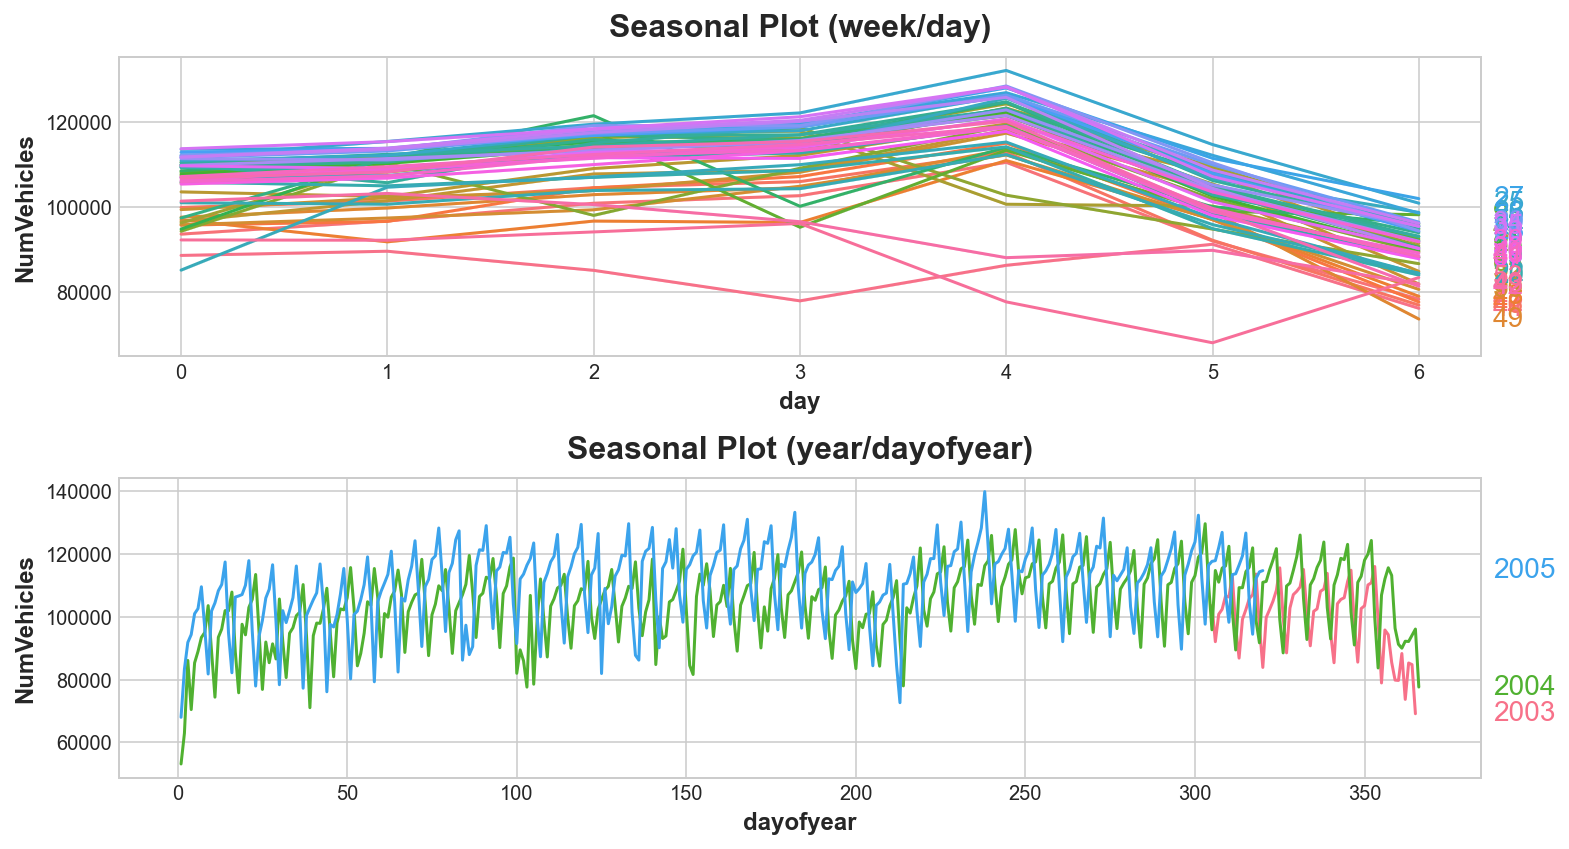

In [3]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1)

plt.show()

Agora vamos ao periodograma:

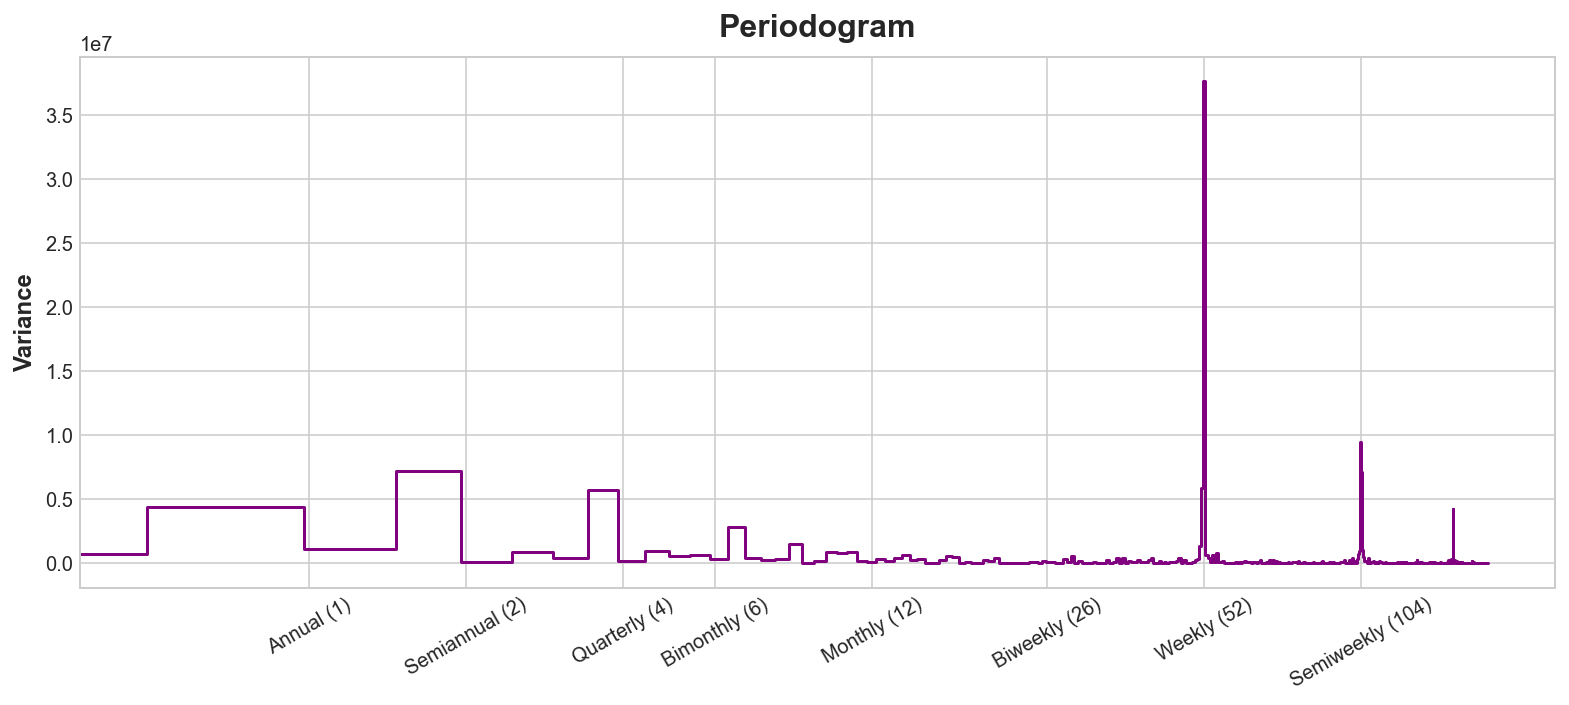

In [4]:
plot_periodogram(tunnel.NumVehicles)
plt.show()

O periodograma está de acordo com os gráficos sazonais acima: uma estação semanal forte e uma estação anual mais fraca. A temporada semanal modelaremos com indicadores e a temporada anual com recursos de Fourier. Da direita para a esquerda, o periodograma cai entre Bimestral (6) e Mensal (12), então vamos usar 10 pares de Fourier.

Criaremos nossos recursos sazonais usando DeterministicProcess, o mesmo utilitário que usamos na Lição 2 para criar recursos de tendência. Para usar dois períodos sazonais (semanal e anual), precisaremos instanciar um deles como um "termo adicional":

In [5]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

Com nosso conjunto de recursos criado, estamos prontos para ajustar o modelo e fazer previsões. Adicionaremos uma previsão de 90 dias para ver como nosso modelo extrapola além dos dados de treinamento. O código aqui é o mesmo que nas lições anteriores.

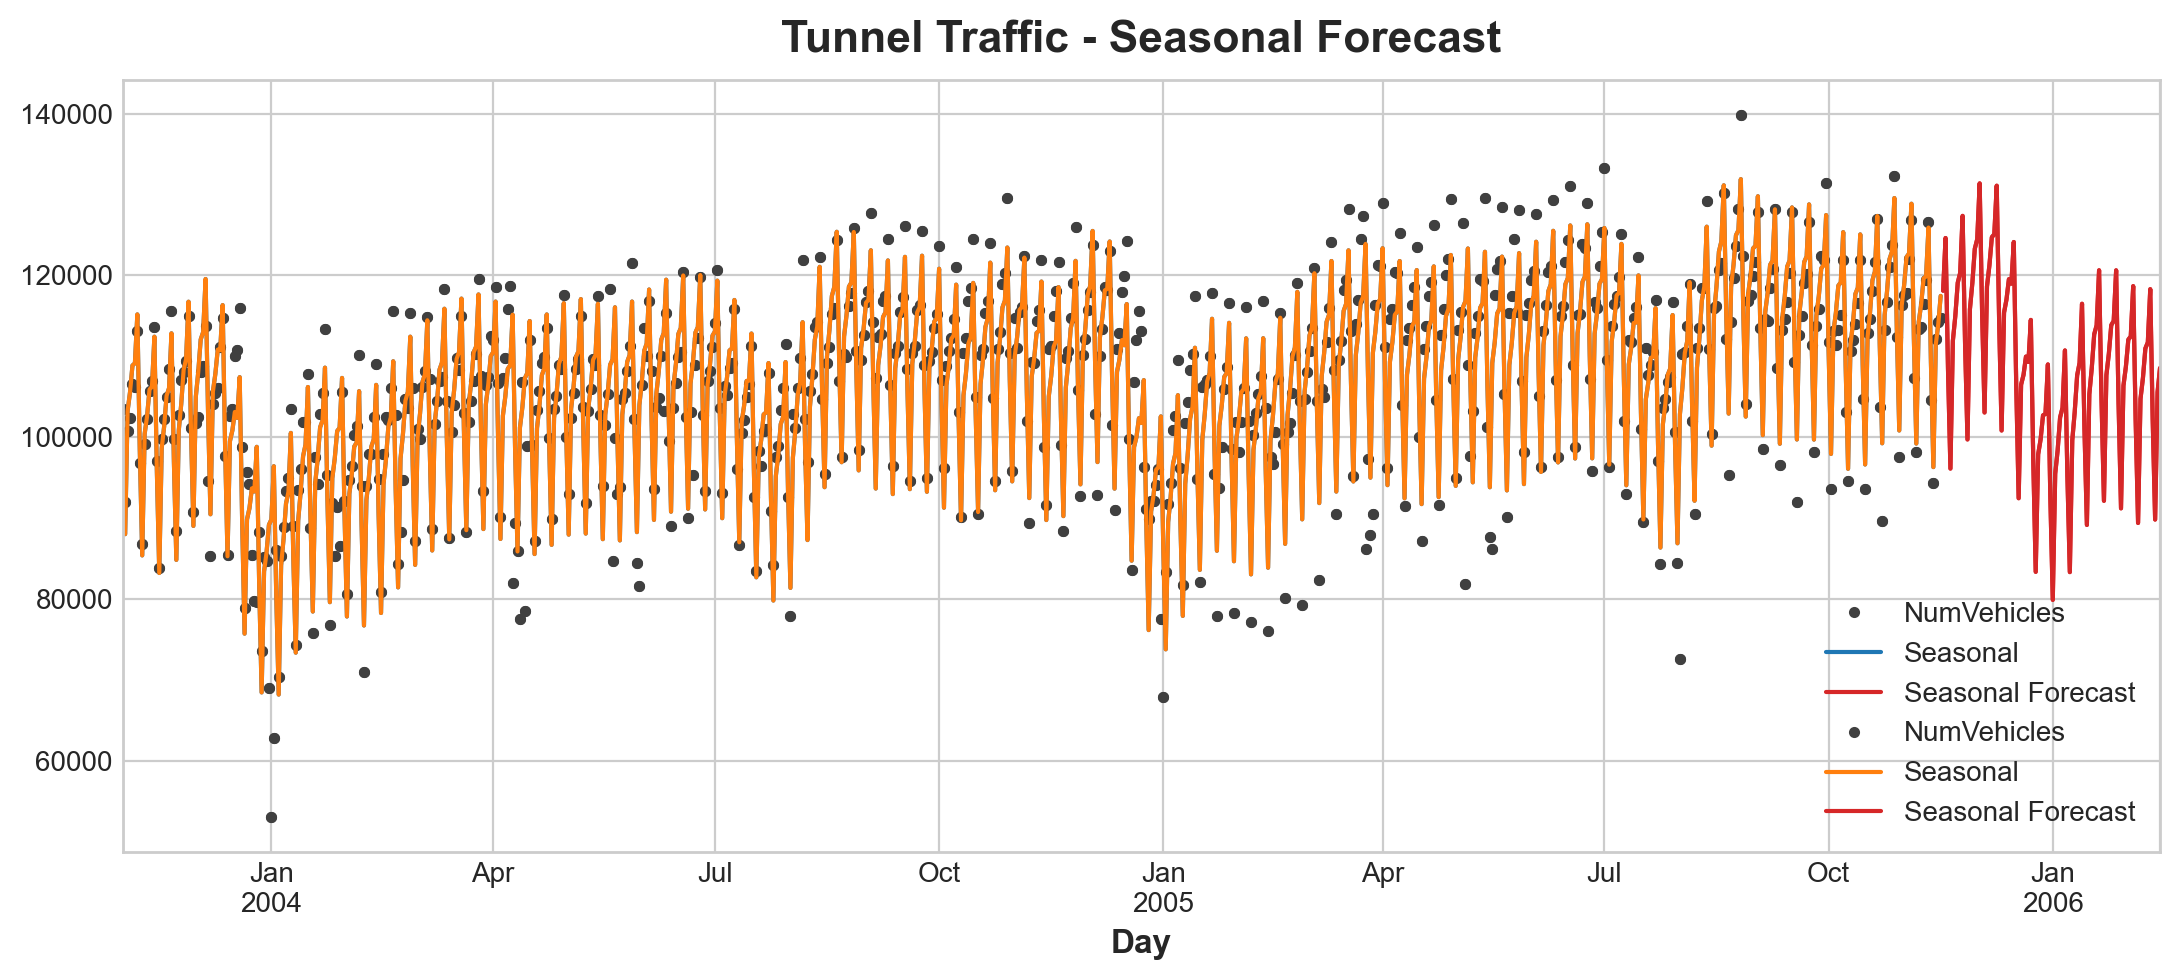

In [17]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

plt.show()

Ainda podemos fazer mais com séries temporais para melhorar nossas previsões. Na próxima lição, aprenderemos como usar as próprias séries temporais como recursos. O uso de séries temporais como entradas para uma previsão nos permite modelar outro componente frequentemente encontrado em séries: ciclos.